In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#for boosting classification purposes
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Feature Fusion: Concatenating all feature extraction techniques
from scipy.sparse import hstack

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Loading dataset
spam_df = pd.read_csv("/content/spam.csv")

In [ ]:
#inspecting the data
spam_df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [ ]:
# Turning spam/ham into numerical data
spam_df['spam'] = spam_df['Category'].apply(lambda x:1 if x=='spam' else 0)

In [ ]:
spam_df

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will ü b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


In [ ]:
# Splitting data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(spam_df['Message'], spam_df['spam'], test_size=0.25, random_state=42)

In [ ]:
# Feature Extraction: Count Vectorizer
cv = CountVectorizer()
x_train_cv = cv.fit_transform(x_train)
x_test_cv = cv.transform(x_test)

In [ ]:
x_train_cv.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Feature Extraction: TF-IDF Vectorizer
tfidf = TfidfVectorizer(min_df=1, stop_words="english", lowercase=True)
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

In [ ]:
x_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Feature Extraction: Word Embeddings (Word2Vec)
def tokenize_text(text):
    return [nltk.word_tokenize(sentence.lower()) for sentence in nltk.sent_tokenize(text)]

In [ ]:
# Tokenizing the text for Word2Vec training
x_train_tokens = [tokenize_text(message) for message in x_train]
x_test_tokens = [tokenize_text(message) for message in x_test]

In [ ]:
# Training Word2Vec model
word2vec_model = Word2Vec([word for message in x_train_tokens for word in message], vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Create a function to convert text to word embedding vectors
def get_average_word2vec(tokens_list, vector, generate_missing=False):
    if len(tokens_list)<1:
        return np.zeros(vector.vector_size)
    vectorized = [vector.wv[word] if word in vector.wv else np.zeros(vector.vector_size) for word in tokens_list]
    return np.mean(vectorized, axis=0)

In [ ]:
# Apply the word embeddings to the training and test data
x_train_w2v = np.array([get_average_word2vec(nltk.word_tokenize(text), word2vec_model) for text in x_train])
x_test_w2v = np.array([get_average_word2vec(nltk.word_tokenize(text), word2vec_model) for text in x_test])

In [ ]:
print(x_train_w2v)

[[-0.11616687  0.43811884 -0.10064054 ... -0.3254554  -0.06389221
  -0.03034013]
 [-0.14478221  0.46622867 -0.11993682 ... -0.35301346 -0.08411562
  -0.04631861]
 [-0.24500769  0.62142783 -0.19120902 ... -0.49231675 -0.1498107
  -0.07462263]
 ...
 [-0.16695707  0.54297746 -0.15717246 ... -0.41726885 -0.09986375
  -0.0325966 ]
 [-0.12948339  0.26222008 -0.09817073 ... -0.20832047 -0.08271818
  -0.03845534]
 [-0.11762857  0.41558511 -0.10235772 ... -0.30469973 -0.06933334
  -0.03677245]]


In [ ]:
# Model Training: Multinomial Naive Bayes
nb_model = MultinomialNB()

In [ ]:
# Count Vectorizer + Naive Bayes
nb_model.fit(x_train_cv, y_train)
y_pred_nb_cv = nb_model.predict(x_test_cv)
print("Naive Bayes with Count Vectorizer Accuracy:", accuracy_score(y_test, y_pred_nb_cv))

Naive Bayes with Count Vectorizer Accuracy: 0.9885139985642498


In [ ]:
# TF-IDF Vectorizer + Naive Bayes
nb_model.fit(x_train_tfidf, y_train)
y_pred_nb_tfidf = nb_model.predict(x_test_tfidf)
print("Naive Bayes with TF-IDF Vectorizer Accuracy:", accuracy_score(y_test, y_pred_nb_tfidf))

Naive Bayes with TF-IDF Vectorizer Accuracy: 0.9727207465900933


In [ ]:
# Model Training: Logistic Regression
lr_model = LogisticRegression(max_iter=1000)

In [ ]:
# Count Vectorizer + Logistic Regression
lr_model.fit(x_train_cv, y_train)
y_pred_lr_cv = lr_model.predict(x_test_cv)
print("Logistic Regression with Count Vectorizer Accuracy:", accuracy_score(y_test, y_pred_lr_cv))

Logistic Regression with Count Vectorizer Accuracy: 0.9834888729361091


In [ ]:
# TF-IDF Vectorizer + Logistic Regression
lr_model.fit(x_train_tfidf, y_train)
y_pred_lr_tfidf = lr_model.predict(x_test_tfidf)
print("Logistic Regression with TF-IDF Vectorizer Accuracy:", accuracy_score(y_test, y_pred_lr_tfidf))

Logistic Regression with TF-IDF Vectorizer Accuracy: 0.9662598707824839


In [ ]:
# Word Embeddings + Logistic Regression
lr_model.fit(x_train_w2v, y_train)
y_pred_lr_w2v = lr_model.predict(x_test_w2v)
print("Logistic Regression with Word Embeddings Accuracy:", accuracy_score(y_test, y_pred_lr_w2v))

Logistic Regression with Word Embeddings Accuracy: 0.8557071069633884


In [ ]:
# Initialize AdaBoost with base estimator (default is DecisionTree)
ada_model = AdaBoostClassifier(n_estimators=100)

In [ ]:
# Fit model on Count Vectorizer features
ada_model.fit(x_train_cv, y_train)
y_pred_ada_cv = ada_model.predict(x_test_cv)
print("AdaBoost with Count Vectorizer Accuracy:", accuracy_score(y_test, y_pred_ada_cv))


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost with Count Vectorizer Accuracy: 0.9798994974874372


In [ ]:
# Fit model on TF-IDF features
ada_model.fit(x_train_tfidf, y_train)
y_pred_ada_tfidf = ada_model.predict(x_test_tfidf)
print("AdaBoost with TF-IDF Vectorizer Accuracy:", accuracy_score(y_test, y_pred_ada_tfidf))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost with TF-IDF Vectorizer Accuracy: 0.9806173725771715


In [ ]:
# Fit model on Word Embeddings
ada_model.fit(x_train_w2v, y_train)
y_pred_ada_w2v = ada_model.predict(x_test_w2v)
print("AdaBoost with Word Embeddings Accuracy:", accuracy_score(y_test, y_pred_ada_w2v))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost with Word Embeddings Accuracy: 0.9081119885139985


In [ ]:
# Initialize Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100)

In [ ]:
# Count Vectorizer + Gradient Boosting
gb_model.fit(x_train_cv, y_train)
y_pred_gb_cv = gb_model.predict(x_test_cv)
print("Gradient Boosting with Count Vectorizer Accuracy:", accuracy_score(y_test, y_pred_gb_cv))

Gradient Boosting with Count Vectorizer Accuracy: 0.9770279971284996


In [ ]:
# TF-IDF Vectorizer + Gradient Boosting
gb_model.fit(x_train_tfidf, y_train)
y_pred_gb_tfidf = gb_model.predict(x_test_tfidf)
print("Gradient Boosting with TF-IDF Vectorizer Accuracy:", accuracy_score(y_test, y_pred_gb_tfidf))


Gradient Boosting with TF-IDF Vectorizer Accuracy: 0.9669777458722182


In [ ]:
# Word Embeddings + Gradient Boosting
gb_model.fit(x_train_w2v, y_train)
y_pred_gb_w2v = gb_model.predict(x_test_w2v)
print("Gradient Boosting with Word Embeddings Accuracy:", accuracy_score(y_test, y_pred_gb_w2v))

Gradient Boosting with Word Embeddings Accuracy: 0.9231873653984207


In [ ]:
# Initialize XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')

In [ ]:
# Count Vectorizer + XGBoost
xgb_model.fit(x_train_cv, y_train)
y_pred_xgb_cv = xgb_model.predict(x_test_cv)
print("XGBoost with Count Vectorizer Accuracy:", accuracy_score(y_test, y_pred_xgb_cv))

XGBoost with Count Vectorizer Accuracy: 0.9806173725771715


In [ ]:
# TF-IDF Vectorizer + XGBoost
xgb_model.fit(x_train_tfidf, y_train)
y_pred_xgb_tfidf = xgb_model.predict(x_test_tfidf)
print("XGBoost with TF-IDF Vectorizer Accuracy:", accuracy_score(y_test, y_pred_xgb_tfidf))

XGBoost with TF-IDF Vectorizer Accuracy: 0.9770279971284996


In [ ]:
# Word Embeddings + XGBoost
xgb_model.fit(x_train_w2v, y_train)
y_pred_xgb_w2v = xgb_model.predict(x_test_w2v)
print("XGBoost with Word Embeddings Accuracy:", accuracy_score(y_test, y_pred_xgb_w2v))

XGBoost with Word Embeddings Accuracy: 0.9411342426417804


In [ ]:
# Initialize LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=100, verbose=-1)

In [ ]:
x_train_cv_1 = x_train_cv.astype(np.float32)
x_test_cv_1 = x_test_cv.astype(np.float32)

# Count Vectorizer + LightGBM
lgb_model.fit(x_train_cv_1, y_train)
y_pred_lgb_cv = lgb_model.predict(x_test_cv_1)
print("LightGBM with Count Vectorizer Accuracy:", accuracy_score(y_test, y_pred_lgb_cv))

LightGBM with Count Vectorizer Accuracy: 0.9820531227566404


In [ ]:
# TF-IDF Vectorizer + LightGBM
lgb_model.fit(x_train_tfidf, y_train)
y_pred_lgb_tfidf = lgb_model.predict(x_test_tfidf)
print("LightGBM with TF-IDF Vectorizer Accuracy:", accuracy_score(y_test, y_pred_lgb_tfidf))

LightGBM with TF-IDF Vectorizer Accuracy: 0.9777458722182341


In [ ]:
# Word Embeddings + LightGBM
lgb_model.fit(x_train_w2v, y_train)
y_pred_lgb_w2v = lgb_model.predict(x_test_w2v)
print("LightGBM with Word Embeddings Accuracy:", accuracy_score(y_test, y_pred_lgb_w2v))

LightGBM with Word Embeddings Accuracy: 0.9440057430007178


In [ ]:
# As we have previously converted word2Vec into float now we are converting Count Vectorizer features into float
x_train_cv_1 = x_train_cv.astype(np.float32)
x_test_cv_1 = x_test_cv.astype(np.float32)

In [ ]:
# Convert TF-IDF features to a sparse format
x_train_tfidf_1 = x_train_tfidf.astype(np.float32)
x_test_tfidf_1 = x_test_tfidf.astype(np.float32)

In [ ]:
# Transform Word2Vec embeddings to absolute values because we can't use negative values for multinomial naive bayes
x_train_w2v_abs = np.abs(x_train_w2v)
x_test_w2v_abs = np.abs(x_test_w2v)

In [ ]:
# # Concatenate Count Vectorizer, TF-IDF, and transformed Word2Vec features
x_train_fusion = hstack([x_train_cv_1, x_train_tfidf_1, x_train_w2v_abs])
x_test_fusion = hstack([x_test_cv_1, x_test_tfidf_1, x_test_w2v_abs])

In [ ]:
# Train Multinomial Naive Bayes with the concatenated features
nb_model.fit(x_train_fusion, y_train)
y_pred_nb_fusion = nb_model.predict(x_test_fusion)
print("Naive Bayes with Feature Fusion Accuracy:", accuracy_score(y_test, y_pred_nb_fusion))

Naive Bayes with Feature Fusion Accuracy: 0.9834888729361091


In [ ]:
# Model Training: Logistic Regression
lr_model.fit(x_train_fusion, y_train)
y_pred_lr_fusion = lr_model.predict(x_test_fusion)
print("Logistic Regression with Feature Fusion Accuracy:", accuracy_score(y_test, y_pred_lr_fusion))

Logistic Regression with Feature Fusion Accuracy: 0.9849246231155779


In [ ]:
# Initialize and fit AdaBoost
ada_model.fit(x_train_fusion, y_train)
y_pred_ada_fusion = ada_model.predict(x_test_fusion)
print("AdaBoost with Feature Fusion Accuracy:", accuracy_score(y_test, y_pred_ada_fusion))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost with Feature Fusion Accuracy: 0.9834888729361091


In [ ]:
# Initialize and fit Gradient Boosting
gb_model.fit(x_train_fusion, y_train)
y_pred_gb_fusion = gb_model.predict(x_test_fusion)
print("Gradient Boosting with Feature Fusion Accuracy:", accuracy_score(y_test, y_pred_gb_fusion))

Gradient Boosting with Feature Fusion Accuracy: 0.9763101220387652


In [ ]:
# Initialize and fit XGBoost
xgb_model.fit(x_train_fusion, y_train)
y_pred_xgb_fusion = xgb_model.predict(x_test_fusion)
print("XGBoost with Feature Fusion Accuracy:", accuracy_score(y_test, y_pred_xgb_fusion))

XGBoost with Feature Fusion Accuracy: 0.9820531227566404


In [ ]:
# Initialize and fit LightGBM
lgb_model.fit(x_train_fusion, y_train)
y_pred_lgb_fusion = lgb_model.predict(x_test_fusion)
print("LightGBM with Feature Fusion Accuracy:", accuracy_score(y_test, y_pred_lgb_fusion))

LightGBM with Feature Fusion Accuracy: 0.9863603732950467


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


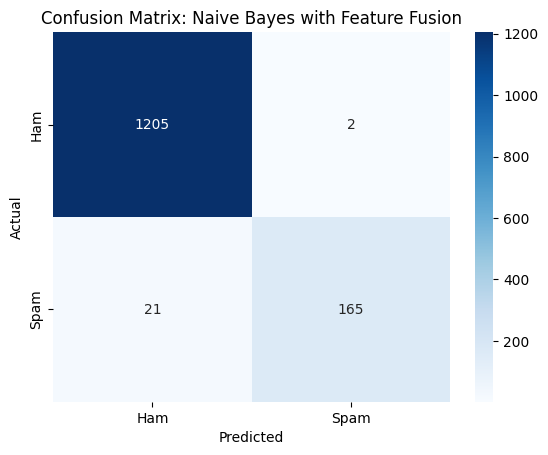

In [ ]:
# Confusion Matrix for Naive Bayes with Feature Fusion
y_pred_nb_fusion = nb_model.predict(x_test_fusion)
cm_nb = confusion_matrix(y_test, y_pred_nb_fusion)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix: Naive Bayes with Feature Fusion")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# ROC Curve for Naive Bayes with Feature Fusion
y_pred_nb_fusion_proba = nb_model.predict_proba(x_test_fusion)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb_fusion_proba)
roc_auc_nb = auc(fpr_nb, tpr_nb)

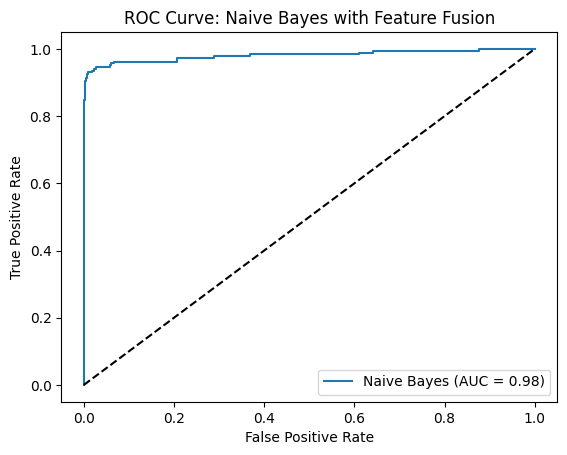

In [ ]:
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Naive Bayes with Feature Fusion')
plt.legend(loc="lower right")
plt.show()

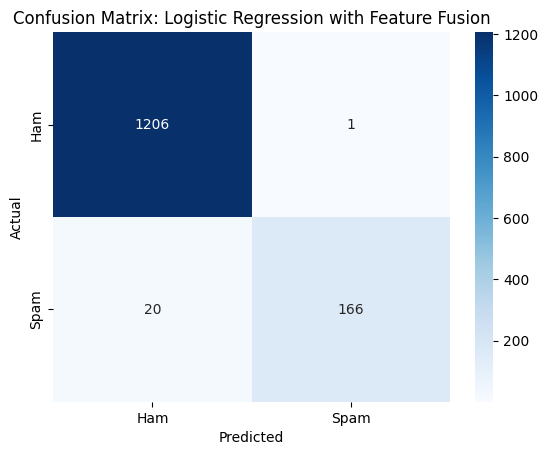

In [ ]:
# Confusion Matrix for Logistic Regression with Feature Fusion
y_pred_lr_fusion = lr_model.predict(x_test_fusion)
cm_lr = confusion_matrix(y_test, y_pred_lr_fusion)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix: Logistic Regression with Feature Fusion")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# ROC Curve for Logistic Regression with Feature Fusion
y_pred_lr_fusion_proba = lr_model.predict_proba(x_test_fusion)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_fusion_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

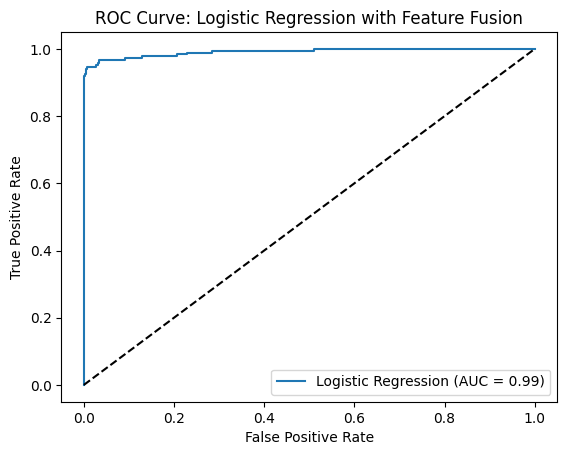

In [ ]:
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression with Feature Fusion')
plt.legend(loc="lower right")
plt.show()

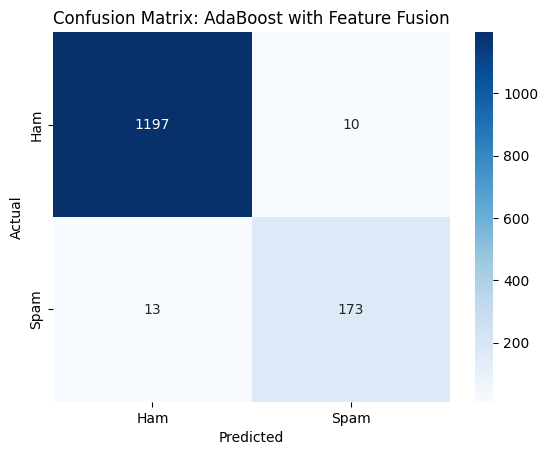

In [ ]:
# Confusion Matrix for AdaBoost with Feature Fusion
y_pred_ada_fusion = ada_model.predict(x_test_fusion)
cm_ada = confusion_matrix(y_test, y_pred_ada_fusion)
sns.heatmap(cm_ada, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix: AdaBoost with Feature Fusion")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# ROC Curve for AdaBoost with Feature Fusion
y_pred_ada_fusion_proba = ada_model.predict_proba(x_test_fusion)[:, 1]
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_pred_ada_fusion_proba)
roc_auc_ada = auc(fpr_ada, tpr_ada)

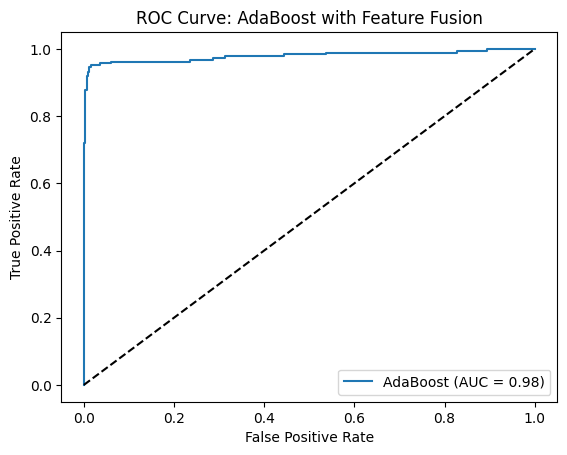

In [ ]:
plt.plot(fpr_ada, tpr_ada, label=f'AdaBoost (AUC = {roc_auc_ada:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: AdaBoost with Feature Fusion')
plt.legend(loc="lower right")
plt.show()

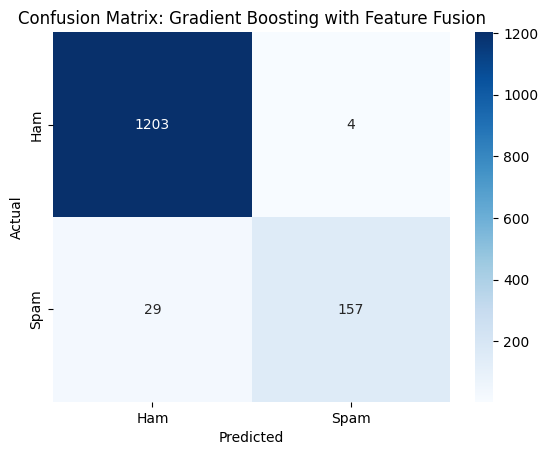

In [ ]:
# Confusion Matrix for Gradient Boosting with Feature Fusion
y_pred_gb_fusion = gb_model.predict(x_test_fusion)
cm_gb = confusion_matrix(y_test, y_pred_gb_fusion)
sns.heatmap(cm_gb, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix: Gradient Boosting with Feature Fusion")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# ROC Curve for Gradient Boosting with Feature Fusion
y_pred_gb_fusion_proba = gb_model.predict_proba(x_test_fusion)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb_fusion_proba)
roc_auc_gb = auc(fpr_gb, tpr_gb)

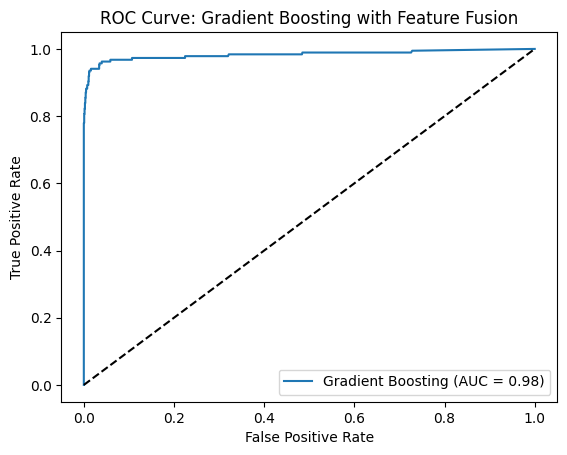

In [ ]:
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Gradient Boosting with Feature Fusion')
plt.legend(loc="lower right")
plt.show()

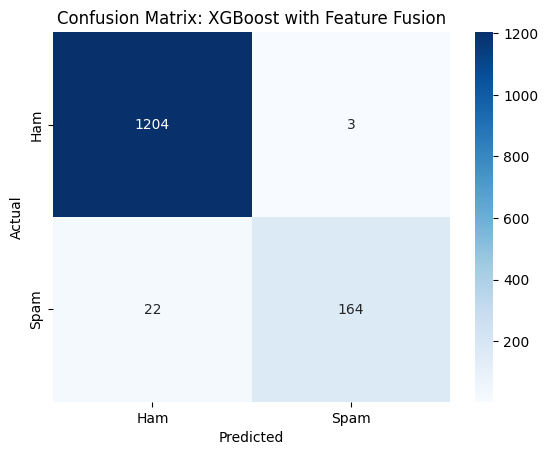

In [ ]:
# Confusion Matrix for XGBoost with Feature Fusion
y_pred_xgb_fusion = xgb_model.predict(x_test_fusion)
cm_xgb = confusion_matrix(y_test, y_pred_xgb_fusion)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix: XGBoost with Feature Fusion")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# ROC Curve for XGBoost with Feature Fusion
y_pred_xgb_fusion_proba = xgb_model.predict_proba(x_test_fusion)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_fusion_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

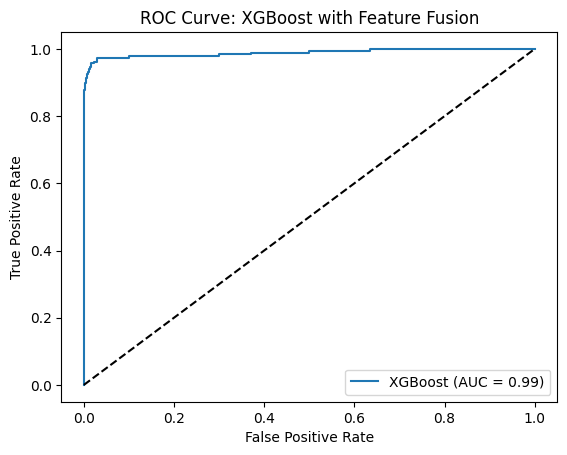

In [ ]:
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: XGBoost with Feature Fusion')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


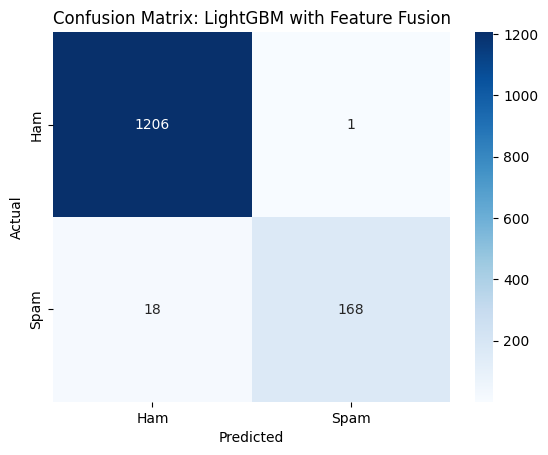

In [ ]:
# Confusion Matrix for LightGBM with Feature Fusion
y_pred_lgb_fusion = lgb_model.predict(x_test_fusion)
cm_lgb = confusion_matrix(y_test, y_pred_lgb_fusion)
sns.heatmap(cm_lgb, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix: LightGBM with Feature Fusion")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# ROC Curve for LightGBM with Feature Fusion
y_pred_lgb_fusion_proba = lgb_model.predict_proba(x_test_fusion)[:, 1]
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_lgb_fusion_proba)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


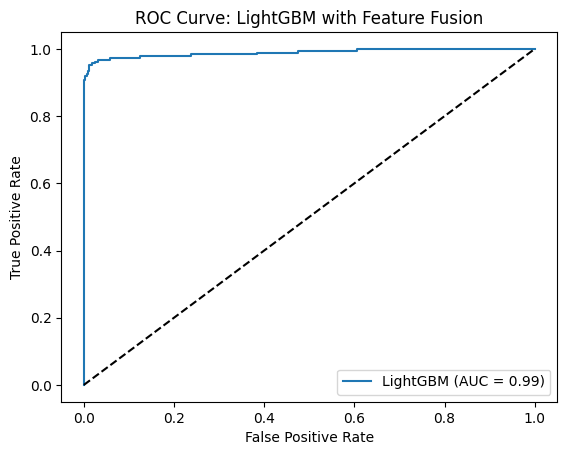

In [ ]:
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {roc_auc_lgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: LightGBM with Feature Fusion')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def print_classification_metrics(y_true, y_pred, model_name, feature_extraction):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"{model_name} + {feature_extraction} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


In [ ]:
# Naive Bayes with Feature Fusion
print_classification_metrics(y_test, y_pred_nb_fusion, "Naive Bayes", "Feature Fusion")

Naive Bayes + Feature Fusion - Precision: 0.9880, Recall: 0.8871, F1-score: 0.9348


In [ ]:
# MNB Count Vectorizer
nb_model_cv = MultinomialNB()
nb_model_cv.fit(x_train_cv, y_train)
y_pred_nb_cv = nb_model_cv.predict(x_test_cv)
print_classification_metrics(y_test, y_pred_nb_cv, "Multinomial Naive Bayes", "Count Vectorizer")


Multinomial Naive Bayes + Count Vectorizer - Precision: 0.9775, Recall: 0.9355, F1-score: 0.9560


In [ ]:
# Refit the model with TF-IDF Vectorizer
nb_model_tfidf = MultinomialNB()
nb_model_tfidf.fit(x_train_tfidf, y_train)
y_pred_nb_tfidf = nb_model_tfidf.predict(x_test_tfidf)
print_classification_metrics(y_test, y_pred_nb_tfidf, "Multinomial Naive Bayes", "TF-IDF Vectorizer")

Multinomial Naive Bayes + TF-IDF Vectorizer - Precision: 0.9933, Recall: 0.8011, F1-score: 0.8869


In [ ]:
# Refit the model with Word2Vec embeddings (transformed to positive values)
nb_model_w2v = MultinomialNB()
nb_model_w2v.fit(x_train_w2v_abs, y_train)  # Using absolute values
y_pred_nb_w2v = nb_model_w2v.predict(x_test_w2v_abs)
print_classification_metrics(y_test, y_pred_nb_w2v, "Multinomial Naive Bayes", "Word2Vec")

Multinomial Naive Bayes + Word2Vec - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Logistic Regression with Feature Fusion
print_classification_metrics(y_test, y_pred_lr_fusion, "Logistic Regression","Feature Fusion")

Logistic Regression + Feature Fusion - Precision: 0.9940, Recall: 0.8925, F1-score: 0.9405


In [ ]:
# Refit the model with Count Vectorizer
lr_model_cv = LogisticRegression(max_iter=1000)
lr_model_cv.fit(x_train_cv, y_train)
y_pred_lr_cv = lr_model_cv.predict(x_test_cv)
print_classification_metrics(y_test, y_pred_lr_cv, "Logistic Regression", "Count Vectorizer")

Logistic Regression + Count Vectorizer - Precision: 1.0000, Recall: 0.8763, F1-score: 0.9341


In [ ]:
# Refit the model with TF-IDF Vectorizer
lr_model_tfidf = LogisticRegression(max_iter=1000)
lr_model_tfidf.fit(x_train_tfidf, y_train)
y_pred_lr_tfidf = lr_model_tfidf.predict(x_test_tfidf)
print_classification_metrics(y_test, y_pred_lr_tfidf, "Logistic Regression", "TF-IDF Vectorizer")

Logistic Regression + TF-IDF Vectorizer - Precision: 1.0000, Recall: 0.7473, F1-score: 0.8554


In [ ]:
# Refit the model with Word2Vec embeddings
lr_model_w2v = LogisticRegression(max_iter=1000)
lr_model_w2v.fit(x_train_w2v, y_train)
y_pred_lr_w2v = lr_model_w2v.predict(x_test_w2v)
print_classification_metrics(y_test, y_pred_lr_w2v, "Logistic Regression", "Word2Vec")

Logistic Regression + Word2Vec - Precision: 0.1053, Recall: 0.0108, F1-score: 0.0195


In [ ]:
# AdaBoost with Feature Fusion
print_classification_metrics(y_test, y_pred_ada_fusion, "AdaBoost", "Feature Fusion")

AdaBoost + Feature Fusion - Precision: 0.9454, Recall: 0.9301, F1-score: 0.9377


In [ ]:
# Refit the model with Count Vectorizer
ada_model_cv = AdaBoostClassifier(n_estimators=100)
ada_model_cv.fit(x_train_cv, y_train)
y_pred_ada_cv = ada_model_cv.predict(x_test_cv)
print_classification_metrics(y_test, y_pred_ada_cv, "AdaBoost", "Count Vectorizer")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost + Count Vectorizer - Precision: 0.9701, Recall: 0.8710, F1-score: 0.9178


In [ ]:
# Refit the model with TF-IDF Vectorizer
ada_model_tfidf = AdaBoostClassifier(n_estimators=100)
ada_model_tfidf.fit(x_train_tfidf, y_train)
y_pred_ada_tfidf = ada_model_tfidf.predict(x_test_tfidf)
print_classification_metrics(y_test, y_pred_ada_tfidf, "AdaBoost", "TF-IDF Vectorizer")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost + TF-IDF Vectorizer - Precision: 0.9706, Recall: 0.8871, F1-score: 0.9270


In [ ]:
# Refit the model with Word2Vec embeddings
ada_model_w2v = AdaBoostClassifier(n_estimators=100)
ada_model_w2v.fit(x_train_w2v_abs, y_train)  # Assuming you are using absolute values for the embeddings
y_pred_ada_w2v = ada_model_w2v.predict(x_test_w2v_abs)
print_classification_metrics(y_test, y_pred_ada_w2v, "AdaBoost", "Word2Vec")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost + Word2Vec - Precision: 0.6810, Recall: 0.5968, F1-score: 0.6361


In [ ]:
# Gradient Boosting with Feature Fusion
print_classification_metrics(y_test, y_pred_gb_fusion, "Gradient Boosting", "Feature Fusion")

Gradient Boosting + Feature Fusion - Precision: 0.9752, Recall: 0.8441, F1-score: 0.9049


In [ ]:
# Refit the model with Count Vectorizer
gb_model_cv = GradientBoostingClassifier(n_estimators=100)
gb_model_cv.fit(x_train_cv, y_train)
y_pred_gb_cv = gb_model_cv.predict(x_test_cv)
print_classification_metrics(y_test, y_pred_gb_cv, "Gradient Boosting", "Count Vectorizer")

Gradient Boosting + Count Vectorizer - Precision: 0.9936, Recall: 0.8387, F1-score: 0.9096


In [ ]:
# Refit the model with TF-IDF Vectorizer
gb_model_tfidf = GradientBoostingClassifier(n_estimators=100)
gb_model_tfidf.fit(x_train_tfidf, y_train)
y_pred_gb_tfidf = gb_model_tfidf.predict(x_test_tfidf)
print_classification_metrics(y_test, y_pred_gb_tfidf, "Gradient Boosting", "TF-IDF Vectorizer")

Gradient Boosting + TF-IDF Vectorizer - Precision: 1.0000, Recall: 0.7634, F1-score: 0.8659


In [ ]:
# Refit the model with Word2Vec embeddings
gb_model_w2v = GradientBoostingClassifier(n_estimators=100)
gb_model_w2v.fit(x_train_w2v_abs, y_train)  # Assuming you are using absolute values for the embeddings
y_pred_gb_w2v = gb_model_w2v.predict(x_test_w2v_abs)
print_classification_metrics(y_test, y_pred_gb_w2v, "Gradient Boosting", "Word2Vec")

Gradient Boosting + Word2Vec - Precision: 0.7447, Recall: 0.5645, F1-score: 0.6422


In [ ]:
# XGBoost with Feature Fusion
print_classification_metrics(y_test, y_pred_xgb_fusion, "XGBoost" , "Feature Fusion")

XGBoost + Feature Fusion - Precision: 0.9820, Recall: 0.8817, F1-score: 0.9292


In [ ]:
# Refit the model with Count Vectorizer
xgb_model_cv = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model_cv.fit(x_train_cv, y_train)
y_pred_xgb_cv = xgb_model_cv.predict(x_test_cv)
print_classification_metrics(y_test, y_pred_xgb_cv, "XGBoost", "Count Vectorizer")

XGBoost + Count Vectorizer - Precision: 0.9760, Recall: 0.8763, F1-score: 0.9235


In [ ]:
# Refit the model with TF-IDF Vectorizer
xgb_model_tfidf = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model_tfidf.fit(x_train_tfidf, y_train)
y_pred_xgb_tfidf = xgb_model_tfidf.predict(x_test_tfidf)
print_classification_metrics(y_test, y_pred_xgb_tfidf, "XGBoost", "TF-IDF Vectorizer")

XGBoost + TF-IDF Vectorizer - Precision: 0.9639, Recall: 0.8602, F1-score: 0.9091


In [ ]:
# Refit the model with Word2Vec embeddings
xgb_model_w2v = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model_w2v.fit(x_train_w2v_abs, y_train)  # Assuming you are using absolute values for the embeddings
y_pred_xgb_w2v = xgb_model_w2v.predict(x_test_w2v_abs)
print_classification_metrics(y_test, y_pred_xgb_w2v, "XGBoost", "Word2Vec")

XGBoost + Word2Vec - Precision: 0.8075, Recall: 0.6989, F1-score: 0.7493


In [ ]:
# LightGBM with Feature Fusion
print_classification_metrics(y_test, y_pred_lgb_fusion, "LightGBM" , "Feature Fusion")

LightGBM + Feature Fusion - Precision: 0.9941, Recall: 0.9032, F1-score: 0.9465


In [ ]:
# Refit the model with Count Vectorizer
lgb_model_cv = lgb.LGBMClassifier(n_estimators=100, verbose=-1)
lgb_model_cv.fit(x_train_cv_1, y_train)
y_pred_lgb_cv = lgb_model_cv.predict(x_test_cv_1)
print_classification_metrics(y_test, y_pred_lgb_cv, "LightGBM", "Count Vectorizer")

LightGBM + Count Vectorizer - Precision: 0.9763, Recall: 0.8871, F1-score: 0.9296


In [ ]:
# Refit the model with TF-IDF Vectorizer
lgb_model_tfidf = lgb.LGBMClassifier(n_estimators=100, verbose=-1)
lgb_model_tfidf.fit(x_train_tfidf_1, y_train)
y_pred_lgb_tfidf = lgb_model_tfidf.predict(x_test_tfidf_1)
print_classification_metrics(y_test, y_pred_lgb_tfidf, "LightGBM", "TF-IDF Vectorizer")

LightGBM + TF-IDF Vectorizer - Precision: 0.9429, Recall: 0.8871, F1-score: 0.9141


In [ ]:
# Refit the model with Word2Vec embeddings
lgb_model_w2v = lgb.LGBMClassifier(n_estimators=100, verbose=-1)
lgb_model_w2v.fit(x_train_w2v_abs, y_train)  # Assuming you are using absolute values for the embeddings
y_pred_lgb_w2v = lgb_model_w2v.predict(x_test_w2v_abs)
print_classification_metrics(y_test, y_pred_lgb_w2v, "LightGBM", "Word2Vec")

LightGBM + Word2Vec - Precision: 0.8137, Recall: 0.7043, F1-score: 0.7550
